Elisa Stabilini - 28326A

# Esperienza 1 - analisi dati Gaia

In [1]:
%matplotlib inline
from scipy.stats import trim_mean
import statsmodels
from statsmodels import robust
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import astropy
import seaborn as sns

import emcee
import corner

In [2]:
#Fisso le dimensioni delle label e delle informazioni dei plot
plt.rcParams.update({"font.size":15})
plt.rcParams.update({"ytick.direction":"inout"})
plt.rcParams.update({"xtick.direction":"inout"})
plt.rcParams.update({"xtick.major.size":4.5})
plt.rcParams.update({"ytick.major.size":4.5})

In [3]:
from astropy.table import Table
gaia = Table.read("Gaia.vot.gz")

In [4]:
print(len(gaia["l"]))

305486


In [5]:
from astropy import units as u
import math

In [6]:
R0 = 8000*u.parsec
R0 = R0.to(u.km)
print(R0)

2.4685420651930938e+17 km


In [7]:
R0 = R0/u.km

In [8]:
print(R0)

2.4685420651930938e+17


**Start working on data**

In [9]:
print(gaia.info)

<Table length=305486>
         name          dtype    unit                  description                 n_bad
--------------------- ------- -------- ------------------------------------------ -----
                   ra float64      deg                            Right ascension     0
                  dec float64      deg                                Declination     0
             parallax float64      mas                                   Parallax     0
       parallax_error float32      mas                 Standard error of parallax     0
                 pmra float64 mas / yr Proper motion in right ascension direction     0
                pmdec float64 mas / yr     Proper motion in declination direction     0
      phot_g_mean_mag float32      mag                      G-band mean magnitude     3
     phot_bp_mean_mag float32      mag               Integrated BP mean magnitude   323
     phot_rp_mean_mag float32      mag               Integrated RP mean magnitude   319
      radi

In [10]:
radiansl = np.radians(gaia["l"])
sinl = np.sin(radiansl)
cosl = np.cos(radiansl)

In [11]:
gaia.add_columns([radiansl, sinl, cosl], indexes=None, names=["radiansl", "sinl", "cosl"], copy=True, rename_duplicate=False)
gaia.info

<Table length=305486>
         name          dtype    unit                  description                 n_bad
--------------------- ------- -------- ------------------------------------------ -----
                   ra float64      deg                            Right ascension     0
                  dec float64      deg                                Declination     0
             parallax float64      mas                                   Parallax     0
       parallax_error float32      mas                 Standard error of parallax     0
                 pmra float64 mas / yr Proper motion in right ascension direction     0
                pmdec float64 mas / yr     Proper motion in declination direction     0
      phot_g_mean_mag float32      mag                      G-band mean magnitude     3
     phot_bp_mean_mag float32      mag               Integrated BP mean magnitude   323
     phot_rp_mean_mag float32      mag               Integrated RP mean magnitude   319
      radi

In [12]:
distance = [1000/gaia["parallax"][i] for i in range(len(gaia["parallax"]))]
print(distance[0])
distance = [distance[i]*u.parsec for i in range(len(distance))]
print(distance[0])

3906.4350802113977
3906.4350802113977 pc


In [13]:
dkm = [distance[i].to(u.km) for i in range(len(distance))]
print(dkm[0])

1.205399915055974e+17 km


In [14]:
dkm = [dkm[i]/u.km for i in range(len(distance))]
print(dkm[0])
gaia.info

1.205399915055974e+17


<Table length=305486>
         name          dtype    unit                  description                 n_bad
--------------------- ------- -------- ------------------------------------------ -----
                   ra float64      deg                            Right ascension     0
                  dec float64      deg                                Declination     0
             parallax float64      mas                                   Parallax     0
       parallax_error float32      mas                 Standard error of parallax     0
                 pmra float64 mas / yr Proper motion in right ascension direction     0
                pmdec float64 mas / yr     Proper motion in declination direction     0
      phot_g_mean_mag float32      mag                      G-band mean magnitude     3
     phot_bp_mean_mag float32      mag               Integrated BP mean magnitude   323
     phot_rp_mean_mag float32      mag               Integrated RP mean magnitude   319
      radi

Ora per poter lavorare tranquillamente senza preoccuparmi delle unità di misura rimuovo le unità di misura da ciascun dato

In [15]:
rad = [radial for radial in gaia["radial_velocity"]]
err = [error for error in gaia["radial_velocity_error"]]
print(rad[0])
print(err[0])

-20.60491
3.84176


In [16]:
Gaia = gaia.copy()
del Gaia["ra","dec","pmra","pmdec","phot_g_mean_mag", "phot_rp_mean_mag", "phot_bp_mean_mag","radial_velocity", "radial_velocity_error"]
Gaia.add_columns([rad, err, dkm], indexes=None, names=["rad_vel", "err", "dkm"], copy=True, rename_duplicate=False)
Gaia.info

<Table length=305486>
     name       dtype  unit        description            class    
-------------- ------- ---- -------------------------- ------------
      parallax float64  mas                   Parallax MaskedColumn
parallax_error float32  mas Standard error of parallax MaskedColumn
             l float64  deg         Galactic longitude MaskedColumn
             b float64  deg          Galactic latitude MaskedColumn
      radiansl float64                                 MaskedColumn
          sinl float64                                 MaskedColumn
          cosl float64                                 MaskedColumn
       rad_vel float32                                       Column
           err float32                                       Column
           dkm float64                                       Column

In [17]:
gaia["sinl"].dtype

dtype('float64')

### Costruzione del modello per inferenza statistica

In [18]:
#The prior: we opt for a uniform distribution for each parameter, whose lower and upper bounds are given in the 
#lims_down and lims_up arrays, respectively.

lims_up = np.array([400, 20, 40])
lims_down = np.array([50, 0.1, 10])

In [19]:
def loglike(args, dkm, sinl, cosl, data, errors): #logaritmo prior
    
    #i dati che considero sono quelli della velocità radiale di Gaia perchè sono quelli per cui ho costruito il modello
    #l'errore sui dati che considero è quello sulla velocità radiale misurata da Gaia
    #NB: è importante passare i parametri per primi perchè emcee considera come parametri su cui fare inferenza i primi passati
    vrot, Usun, Vsun = args
    
    R_CGS = np.sqrt(R0**2 + dkm**2 - 2*R0*dkm*cosl)
    model = vrot*R0*sinl/R_CGS - vrot*sinl - Vsun*sinl - Usun*cosl
    
    logl = -0.5*np.log(2*np.pi*errors**2) - (data-model)**2/(2*errors**2)
    
    return np.sum(logl)
    

    
def logprior(args): #logaritmo prior
    
    vrot, Usun, Vsun = args
    
    if lims_down[0] < vrot <lims_up[0] and lims_down[1] < Usun <lims_up[1] and  lims_down[2] < Vsun <lims_up[2]:
        return 0.0 #non gli faccio sommare davvero la costante perchè la costante, il parametro additivo non mi modifica la somma
    else:
        return -np.inf #=log(0)
    


def logpost(args, dkm, sinl, cosl, data, errors): #logaritmo posterior
    lp = logprior(args)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return loglike(args, dkm, sinl, cosl, data, errors) + logprior(args)

**Controllo unità di misura per operazioni successive**

In [20]:
R0

<Quantity 2.46854207e+17>

In [21]:
R_CGS = math.sqrt(R0**2 + Gaia["dkm"][0]**2 - 2*R0*Gaia["dkm"][0]*Gaia["cosl"][0])

print(R_CGS)

1.4660699161420333e+17


**Inizializzazione parametri inferenza bayesiana**

In [22]:
nwalkers, ndim = 30, 3

filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [23]:
# We extract the initial guess from a uniform distribution. For each parameter, we extract 15 walkers
start = np.array([50, 0.1, 10]) + np.random.rand(nwalkers, ndim) * np.array([400, 20, 40])
start.shape

(30, 3)

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=(Gaia["dkm"], Gaia["sinl"], Gaia["cosl"], Gaia["rad_vel"], Gaia["err"]), backend=backend)
sampler.run_mcmc(start, 4000, progress=True);

  0%|          | 0/4000 [00:00<?, ?it/s]/home/elisa/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [36:41<00:00,  1.82it/s]


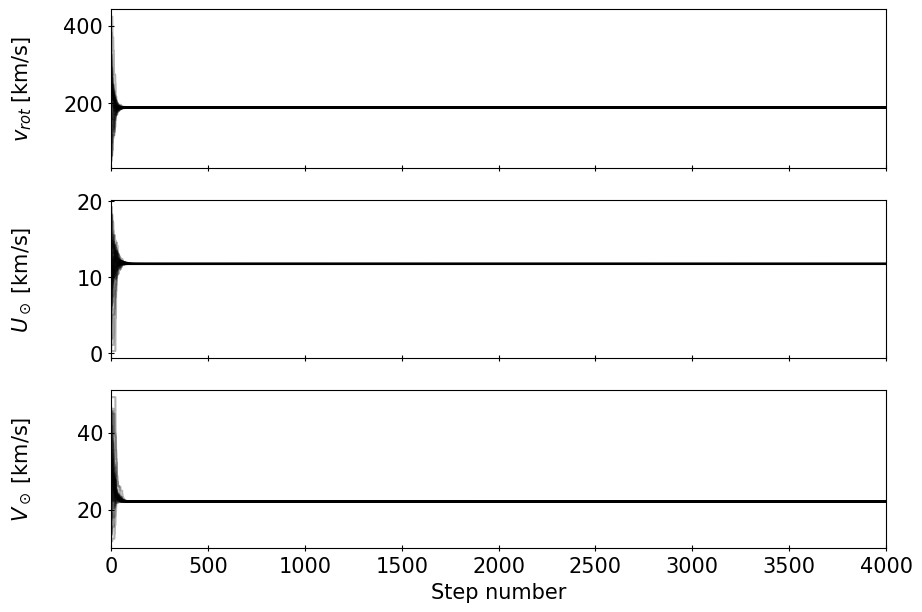

In [25]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$v_{rot} \; [\mathrm{km/s}]$", r"$U_\odot \; [\mathrm{km/s}]$", r"$V_\odot \; [\mathrm{km/s}]$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

In [26]:
# samples is an object containing the values of the parameters for each walker: the first index refers to the number
# of steps, the second index to the number of walkers, whereas the last one to the number of parameters. 

samples.shape

(4000, 30, 3)

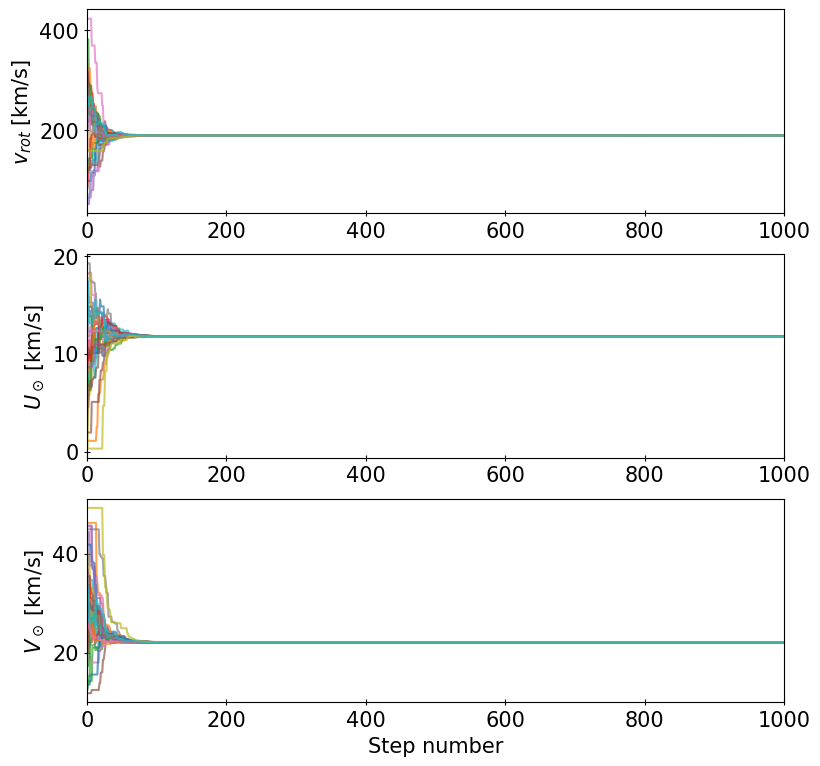

In [27]:
fig, axes = plt.subplots(figsize = (9, 9), ncols = 1, nrows = ndim)

for i in range(ndim):
    for k in range(nwalkers):
        axes[i].plot(samples[:1000, k, i], alpha=0.7)
    axes[i].set_xlim(0, 1000)
    axes[i].set_ylabel(labels[i])

axes[-1].set_xlabel("Step number")
plt.show();

In [28]:
plt.rcParams.update({"font.size":13})

Quantiles:
[(0.025, 189.20674068457004), (0.5, 189.22866938196748), (0.975, 189.25075137924742)]
Quantiles:
[(0.025, 11.760290328938401), (0.5, 11.763978913762323), (0.975, 11.767708360459263)]
Quantiles:
[(0.025, 22.084057539499742), (0.5, 22.08742976366672), (0.975, 22.090855236408814)]


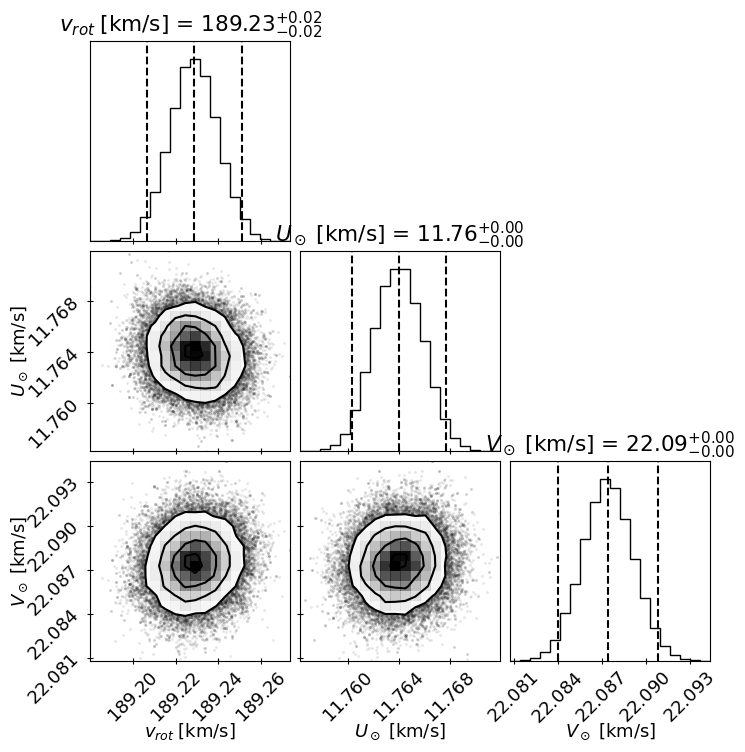

In [29]:
# With sampler.get_chain we get the MCMC chain: we discard the first 600 steps in the chain (burn-in phase), and set 
# thin = 2, i.e. the points are taken every 2 steps (default is 1). 

flat_samples = sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples, labels=labels, 
                    verbose = True,
                    plot_contours = True,
                    use_math_text = True,
                    quantiles = [0.025, 0.5, 0.975], show_titles=True);

In [30]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "$\\mbox{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$" #.xf displays x decimals
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Velocità in funzione della posizione**

In [31]:
Usun = 11.764
Vsun = 22.087
vrot = 189.229

In [32]:
def model(dkm,cosl,sinl):
    R_CGS = np.sqrt(R0**2 + dkm**2 - 2*R0*dkm*cosl)
    return vrot*R0*sinl/R_CGS - vrot*sinl - Vsun*sinl - Usun*cosl

In [33]:
model = model(Gaia["dkm"], Gaia["cosl"], Gaia["sinl"])

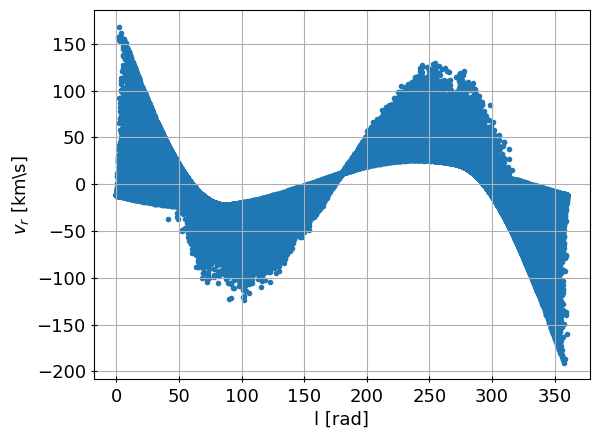

In [34]:
plt.scatter(Gaia["l"], model, marker = '.')
plt.plot()
#plt.scatter(x_valid, y_valid, label='validation data $(x_{valid,i},y_{valid,i})$')
plt.xlabel('l [rad]')
plt.ylabel(r'$v_{r}$ [km\s]')
#plt.legend()
plt.grid(True)
plt.title('')

fig.set_figwidth(15)
fig.set_figheight(5*1)

/home/elisa/miniconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/elisa/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


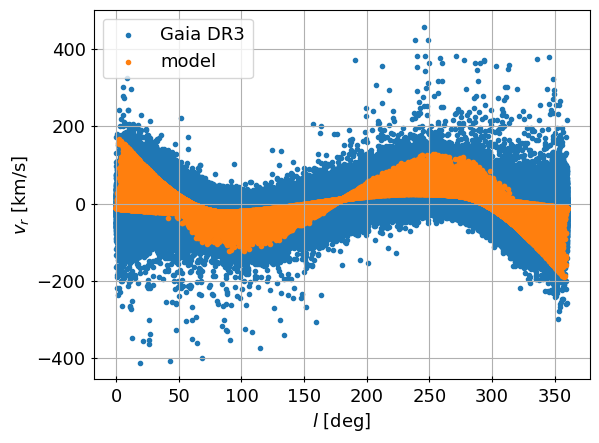

In [35]:
plt.scatter(Gaia["l"], Gaia["rad_vel"], marker = '.', label="Gaia DR3")
plt.scatter(Gaia["l"], model, marker = '.', label="model")

plt.plot()
plt.xlabel(r'$l$ [deg]')
plt.ylabel(r'$v_{r}$ [km/s]')
plt.legend()
plt.grid(True)
plt.title('')

fig.set_figwidth(15)
fig.set_figheight(5*1)

In [36]:
from astropy import coordinates as co

In [37]:
from astropy.coordinates import Angle, Latitude, Longitude

**Scrivo in coordinate galattiche**

In [38]:
c = co.SkyCoord(frame="galactic", l=gaia["l"][0], b=gaia["b"][0], unit="deg")

In [39]:
coord = [co.SkyCoord(frame="galactic", l=gaia["l"][i], b=gaia["b"][i], unit="deg") for i in range(len(gaia["l"]))]

In [40]:
print(coord[0])

<SkyCoord (Galactic): (l, b) in deg
    (335.08544046, -4.06650041)>


**Scrivo in altre coordinate**

In [41]:
c2 = co.SkyCoord(ra=gaia["ra"][0]*u.deg, dec=gaia["dec"][0]*u.deg, distance=distance[0]) 

In [42]:
print(c2)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (251.62249633, -51.62137182, 3906.43508021)>


In [43]:
coord2 = [co.SkyCoord(ra=gaia["ra"][i]*u.deg, dec=gaia["dec"][i]*u.deg, distance=distance[i]) for i in range(len(gaia["l"]))]

In [44]:
print(coord2[0])

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (251.62249633, -51.62137182, 3906.43508021)>


**Converto in coordinate cartesiane**

In [45]:
x = c2.cartesian.x
y = c2.cartesian.y

In [46]:
print(x,y)

-764.6498639731665 pc -2301.6391571601575 pc


In [47]:
cartx = [c.cartesian.x for c in coord2]
carty = [c.cartesian.y for c in coord2]

In [48]:
Gaia.add_columns([cartx, carty], indexes=None, names=["xcoor", "ycoor"], copy=True, rename_duplicate=True)

In [49]:
Gaia.info

<Table length=305486>
     name       dtype  unit        description            class    
-------------- ------- ---- -------------------------- ------------
      parallax float64  mas                   Parallax MaskedColumn
parallax_error float32  mas Standard error of parallax MaskedColumn
             l float64  deg         Galactic longitude MaskedColumn
             b float64  deg          Galactic latitude MaskedColumn
      radiansl float64                                 MaskedColumn
          sinl float64                                 MaskedColumn
          cosl float64                                 MaskedColumn
       rad_vel float32                                       Column
           err float32                                       Column
           dkm float64                                       Column
         xcoor float64   pc                                  Column
         ycoor float64   pc                                  Column

In [50]:
df = Gaia.to_pandas()

In [51]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [52]:
Gaia.add_column(model, name="model", copy=True, rename_duplicate=True)

In [53]:
Gaia.info

<Table length=305486>
     name       dtype  unit        description            class    
-------------- ------- ---- -------------------------- ------------
      parallax float64  mas                   Parallax MaskedColumn
parallax_error float32  mas Standard error of parallax MaskedColumn
             l float64  deg         Galactic longitude MaskedColumn
             b float64  deg          Galactic latitude MaskedColumn
      radiansl float64                                 MaskedColumn
          sinl float64                                 MaskedColumn
          cosl float64                                 MaskedColumn
       rad_vel float32                                       Column
           err float32                                       Column
           dkm float64                                       Column
         xcoor float64   pc                                  Column
         ycoor float64   pc                                  Column
         model float64    

In [54]:
df = Gaia.to_pandas()

/home/elisa/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


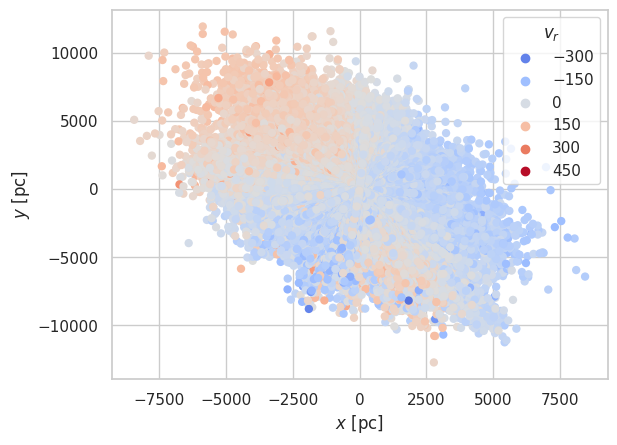

In [58]:
ax = sns.scatterplot(data=df, x="xcoor", y="ycoor", hue="rad_vel",
                palette="coolwarm", sizes=(10, 200), edgecolor="None",                              
)
plt.legend(title=r"$v_{r}$")
plt.xlabel(r"$x$ [pc]")
plt.ylabel(r"$y$ [pc]") 
plt.show()

/home/elisa/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


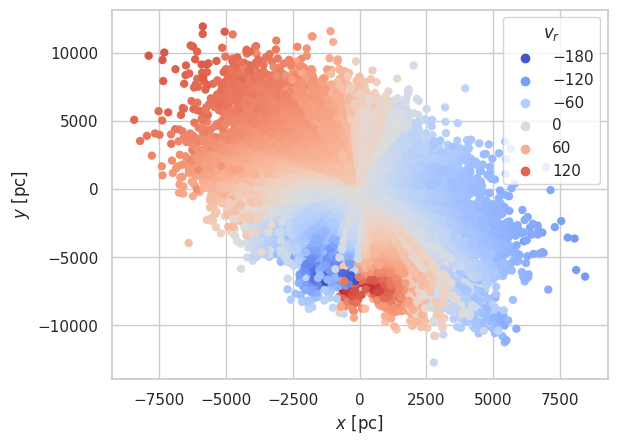

In [59]:
ax = sns.scatterplot(data=df, x="xcoor", y="ycoor", hue="model",
                palette="coolwarm", sizes=(10, 200), edgecolor="None",                              
)
plt.legend(title="$v_{r}$")
plt.xlabel(r"$x$ [pc]")
plt.ylabel(r"$y$ [pc]") 
plt.show()